# Name Classification with Recurrent Nets

Following [this](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) tutorial

### Prepare texts

In [2]:
from __future__ import unicode_literals, print_function, division
import io
import glob
import os
import unicodedata
import string

In [3]:
def findFiles(path): return glob.glob(path)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [4]:
print(findFiles('data/names/*.txt'))

['data/names/Italian.txt', 'data/names/Chinese.txt', 'data/names/Greek.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/English.txt', 'data/names/Polish.txt', 'data/names/Russian.txt', 'data/names/Japanese.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/Portuguese.txt', 'data/names/Korean.txt', 'data/names/Arabic.txt']


In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [6]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [7]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [8]:
print(category_lines['Italian'][:5])


['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turn data into tensors

In [9]:
import torch

In [10]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [11]:
print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Create network

In [12]:
import torch.nn as nn

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories).to(device)

In [16]:
input = letterToTensor('A').to(device)
hidden = torch.zeros(1, n_hidden).to(device)

output, next_hidden = rnn(input, hidden)

In [17]:
input = lineToTensor('Albert').to(device)
hidden = torch.zeros(1, n_hidden).to(device)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9275, -2.9646, -2.7773, -2.9665, -2.9177, -2.7694, -2.8030, -2.9159,
         -2.9548, -2.9016, -2.8494, -2.9064, -2.9396, -2.9867, -2.9103, -2.8051,
         -2.8872, -2.8813]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


### Training

In [18]:
import random
import time
import math


In [19]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
    line_tensor = lineToTensor(line).to(device)
    return category, line, category_tensor, line_tensor


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().to(device)

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
print(categoryFromOutput(output))

('Vietnamese', 5)


In [21]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Strobel
category = French / line = Travers
category = Italian / line = Abbadelli
category = Polish / line = Stawski
category = German / line = Jordan
category = Dutch / line = Lucassen
category = German / line = Hartmann
category = Chinese / line = Shaw
category = Irish / line = O'Dowd
category = Dutch / line = Ven


In [22]:
criterion = nn.NLLLoss()

In [23]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [24]:
n_iters = 100000
print_every = 1000
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 1s) 2.8413 Shang / Italian ✗ (Chinese)
2000 2% (0m 3s) 2.8158 Christodoulou / Korean ✗ (Greek)
3000 3% (0m 5s) 3.0127 Bleskan / Chinese ✗ (Czech)
4000 4% (0m 7s) 2.8026 Foong / Portuguese ✗ (Chinese)
5000 5% (0m 9s) 2.4092 Nitta / Japanese ✓
6000 6% (0m 11s) 2.9066 Mclaughlin / Greek ✗ (Scottish)
7000 7% (0m 13s) 1.6233 Grushevsky / Russian ✓
8000 8% (0m 15s) 2.4349 Okano / Portuguese ✗ (Japanese)
9000 9% (0m 17s) 1.8763 Ha / Korean ✓
10000 10% (0m 19s) 1.7339 Trieu / Vietnamese ✓
11000 11% (0m 21s) 2.2620 Mikhail / Japanese ✗ (Arabic)
12000 12% (0m 22s) 2.8174 Gagin / Arabic ✗ (Russian)
13000 13% (0m 24s) 1.2222 Zhao / Vietnamese ✗ (Chinese)
14000 14% (0m 26s) 1.1677 Benvenuti / Italian ✓
15000 15% (0m 28s) 5.1120 Can / Chinese ✗ (Dutch)
16000 16% (0m 30s) 1.9725 Yeardsley / Dutch ✗ (English)
17000 17% (0m 32s) 0.9879 Szwedko / Polish ✓
18000 18% (0m 34s) 1.9046 Nardi / Arabic ✗ (Italian)
19000 19% (0m 35s) 1.2373 Auer / German ✓
20000 20% (0m 37s) 1.3228 Lesauvage / Frenc

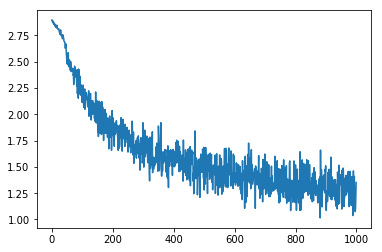

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

### Evaluate results

In [35]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().to(device)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

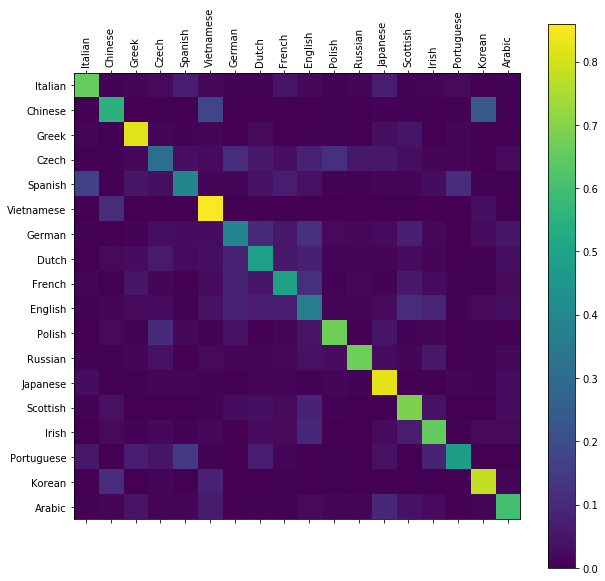

In [36]:
# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### User input

In [32]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line).to(device))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [34]:
predict('Rustem')
predict('Jackson')
predict('Satoshi')


> Rustem
(-0.57) Dutch
(-2.15) English
(-2.43) German

> Jackson
(-0.63) English
(-1.18) Scottish
(-2.52) Russian

> Satoshi
(-0.85) Japanese
(-1.40) Italian
(-1.94) Polish
